## Steps to implement RetinaNet using detectron2
1. Install detectron2
2. Load libraries anda dataset
3. Prepare data for model building
4. Define and train the model

## 1. Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


## 2. Import Required Libraries and Loading Data

In [ ]:
## import required libraries
%matplotlib inline

import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities

## for reading data

from detectron2.data import DatasetCatalog, MetadataCatalog
## loading pretrained weights
from detectron2 import model_zoo
## getting model config file
from detectron2.config import get_cfg
## for training and prediction
from detectron2.engine import DefaultPredictor, DefaultTrainer 
## visualizing data
from detectron2.utils.visualizer import Visualizer

In [ ]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## load and unzip data
!unzip /content/drive/MyDrive/train_zedkk38-200624-203536.zip

## 3. Preparing Data for Model Building

In [ ]:
# read train file
train = pd.read_csv('train.csv')

In [ ]:
# basic cleaning and preprocessing
train['cell_type'] = train['cell_type'].replace({'RBC': 0, 'WBC': 1})
train = train.loc[(train['cell_type'] == 0) | (train['cell_type'] == 1)]

In [ ]:
train.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,1.jpg,0,68,165,154,249
1,1.jpg,0,1,66,145,260
2,1.jpg,0,207,334,160,270
3,1.jpg,0,435,540,347,437
4,1.jpg,0,535,639,356,464


In [ ]:
# define data loader funtion

def bloodCellDet_Converter():
    dataset = []
    for img_name in train.image_names.unique():

      ## empty dict
        det2_dict = {}
        det2_dict['file_name'] = 'images/' + img_name

        ## image width and height 
        det2_dict['width'], det2_dict['height'] = Image.open('images/' + img_name).size
        det2_dict['image_id'] = img_name.split('.')[0]

        ## making annotations list
        annotations = []
        bbox_instances = train[train.image_names == img_name][['xmin', 'ymin', 'xmax', 'ymax']].values.astype('float').tolist()
        category_instances = train[train.image_names == img_name][['cell_type']].values.astype('int').tolist()


        for idx in range(len(bbox_instances)):
            annot = {}
            annot['bbox'] = bbox_instances[idx]
            annot['bbox_mode'] = 0 
            annot['category_id'] = int(category_instances[idx][0])
            annotations.append(annot)

        det2_dict['annotations'] = annotations

        dataset.append(det2_dict)

    return dataset

In [ ]:
## Adding custom dataset to the existing catalog
DatasetCatalog.register("bloodCellDet_dataset", bloodCellDet_Converter)

In [ ]:
## Defining related attributes of the dataset
bloodCellDet_metadata = MetadataCatalog.get("bloodCellDet_dataset").set(thing_classes=["RBC", "WBC"])

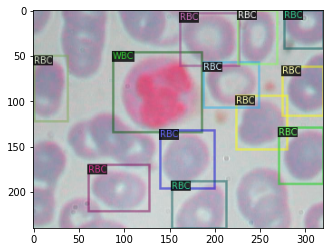

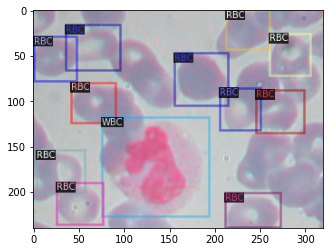

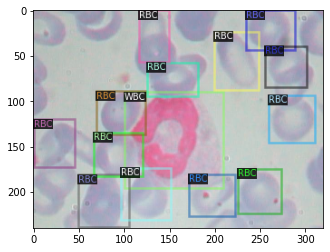

In [ ]:
## visualizing training data

for d in random.sample(bloodCellDet_Converter(), 3):

    img = cv2.imread(d["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=bloodCellDet_metadata, scale=0.5)

    vis = visualizer.draw_dataset_dict(d)
    
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

## 4. Model Building

In [ ]:
## load default cfg file to define model

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml")) 

cfg.DATASETS.TRAIN = ("bloodCellDet_dataset",) 
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 1000  
cfg.MODEL.RETINANET.NUM_CLASSES = 2 

os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
trainer = DefaultTrainer(cfg)        
trainer.resume_or_load(resume = True) 
trainer.train()

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/27 10:03:57 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_bfca0b.pkl: 152MB [00:10, 14.6MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (18, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[07/27 10:04:12 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/27 10:04:32 d2.utils.events]:  eta: 0:06:08  iter: 19  total_loss: 2.163  loss_cls: 1.64  loss_box_reg: 0.5273  time: 0.5228  data_time: 0.0179  lr: 4.9953e-06  max_mem: 1613M
[07/27 10:04:40 d2.utils.events]:  eta: 0:05:55  iter: 39  total_loss: 1.56  loss_cls: 1.184  loss_box_reg: 0.3786  time: 0.4459  data_time: 0.0084  lr: 9.9902e-06  max_mem: 1617M
[07/27 10:04:47 d2.utils.events]:  eta: 0:05:44  iter: 59  total_loss: 1.402  loss_cls: 1.109  loss_box_reg: 0.3267  time: 0.4176  data_time: 0.0067  lr: 1.4985e-05  max_mem: 1632M
[07/27 10:04:54 d2.utils.events]:  eta: 0:05:37  iter: 79  total_loss: 1.594  loss_cls: 1.211  loss_box_reg: 0.384  time: 0.4054  data_time: 0.0081  lr: 1.998e-05  max_mem: 1636M
[07/27 10:05:02 d2.utils.events]:  eta: 0:05:30  iter: 99  total_loss: 1.317  loss_cls: 1.035  loss_box_reg: 0.271  time: 0.3991  data_time: 0.0075  lr: 2.4975e-05  max_mem: 1654M
[07/27 10:05:09 d2.utils.events]:  eta: 0:05:26  iter: 119  total_loss: 1.281  loss_cls: 0.9987  los

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7    
cfg.DATASETS.TEST = ("bloodCellDet_dataset", ) 
predictor = DefaultPredictor(cfg) 

[07/27 10:10:59 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                       | Names in Checkpoint                                                                                  | Shapes                                          |
|:-------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*    | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*    | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*    | backbone.bottom_up.res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight

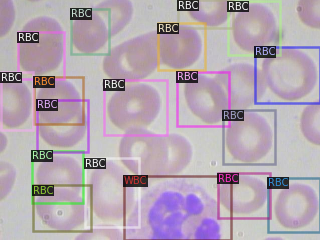

In [ ]:
## visualizing training data

img = bloodCellDet_Converter()[0]
d = (bloodCellDet_Converter()[0]).get('file_name')
im = cv2.imread(d)
v = Visualizer(im[:, :, ::-1],
                metadata=bloodCellDet_metadata, 
                scale=0.5
)
v = v.draw_dataset_dict(img)
cv2_imshow(v.get_image()[:, :, ::-1])

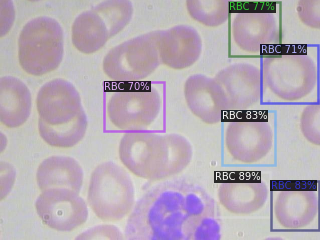

In [ ]:
## visualizing predictions

d = (bloodCellDet_Converter()[0]).get('file_name')
im = cv2.imread(d)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=bloodCellDet_metadata, 
                scale=0.5
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])